#  Learning PyMC3

Loading BokehJS ...


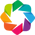

In [1]:
import pymc3 as pm
import theano
import numpy as np
import pandas as pd
import multiprocessing as mp
import bokeh.io
import bokeh.plotting
import holoviews as hv
import scipy.stats
import corner
import matplotlib.pyplot as plt
from tqdm import *
%matplotlib inline
bokeh.io.output_notebook()
hv.extension('bokeh')

The goal of this notebook is to become more familiar with PyMC3. To do so, I'm working through some of the documentation on the [PyMC3](http://docs.pymc.io) website and will try to re-analyze some of the `mwc_induction` data to see if I can get the same results.  

##  Documentation Example - Linear Regression

We want to predicting outcomes $Y$ as some normally-distributed observation with an expectation value of $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$,

$$
\begin{align}
Y &\sim \text{Normal}(\mu, \sigma^2)\\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2.
\end{align}
$$

We can assign normally-distributed priors for $\alpha$ and $\beta_i$ with a mean of zero and a half-normal distribution for $\sigma$. 

### Generating fake data

In [2]:
# Generate linearlly related data with some known seed parameters. 
alpha = 1
sigma = 1
beta_1, beta_2 = [1, 2.5]

# Set the size of the data set. 
data_size = 10000

# Determine the two predictor variables. 
X_1 = np.random.randn(data_size)
X_2 = np.random.randn(data_size) * 0.4

# Simulate the outcome variable. 
Y = alpha + beta_1 * X_1 + beta_2 * X_2 +\
    np.random.randn(data_size) * sigma

# Plot the result
p = bokeh.plotting.figure(x_axis_label='X_i', y_axis_label='Y')
p.scatter(X_1, Y, color='dodgerblue', alpha=0.1, legend='X 1')
p.scatter(X_2, Y, color='tomato', alpha=0.1, legend='X 2')

bokeh.io.show(p)

### Specifying the model

Specifying the model is relatively easy as the syntax closely resembles the statistical notation. 


In [3]:
basic_model = pm.Model()
with basic_model:
    # Set the priors. 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_1 = pm.Normal('beta_1', mu=0, sd=10)
    beta_2 = pm.Normal('beta_2', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Compute the expected value of the outcome. 
    mu = alpha + beta_1 * X_1 + beta_2 * X_2
    
    # Compute the likelihood of the observations. 
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

We can now find the MAP estimate for `basic_model` using numerical optimization methods.  

In [4]:
map_estimate = pm.find_MAP(model=basic_model)
print(map_estimate)

Optimization terminated successfully.
         Current function value: 14221.015541
         Iterations: 17
         Function evaluations: 25
         Gradient evaluations: 25
{'alpha': array(0.9911648296570515), 'beta_1': array(0.987223613452779), 'beta_2': array(2.511535430006243), 'sigma_log_': array(0.002119639373307829)}


Now we can just sample using NUTS. 

In [5]:
with basic_model:
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -14,235: 100%|██████████| 200000/200000 [00:35<00:00, 5558.13it/s]
Finished [100%]: Average ELBO = -14,235
INFO:pymc3:Finished [100%]: Average ELBO = -14,235
100%|██████████| 5000/5000 [00:12<00:00, 601.97it/s]


In [13]:
logp = []
for t in tqdm(trace): 
    logp.append(basic_model.logp(t))
# basic_model.logp(trace[0])
logp

100%|██████████| 5000/5000 [00:00<00:00, 7626.96it/s]


[array(-14225.604132626706),
 array(-14225.604132626706),
 array(-14224.445070352444),
 array(-14223.819777220346),
 array(-14225.648427174547),
 array(-14222.119463114279),
 array(-14222.119463114279),
 array(-14223.26319377682),
 array(-14222.24620519908),
 array(-14222.59157755516),
 array(-14221.58855384879),
 array(-14221.58855384879),
 array(-14223.834434786835),
 array(-14221.986869411256),
 array(-14223.981053603587),
 array(-14221.758447527016),
 array(-14221.758447527016),
 array(-14222.435792841918),
 array(-14223.755696643431),
 array(-14223.035596014246),
 array(-14222.481078170773),
 array(-14222.481078170773),
 array(-14221.461102618927),
 array(-14222.781579157843),
 array(-14222.414299902306),
 array(-14222.317699257967),
 array(-14222.317699257967),
 array(-14222.46175707578),
 array(-14222.532748741058),
 array(-14221.947243302768),
 array(-14222.965426711691),
 array(-14224.002687356136),
 array(-14225.397225127876),
 array(-14221.961769909916),
 array(-14221.219992

In [14]:
def traceframe(trace, model):
    df = pm.trace_to_dataframe(trace)
    lnprob = []
    for t in tqdm(trace):
        lnprob.append(model.logp(t))
    df.insert(np.shape(df)[1], 'lnprob', lnprob)        
    return df

In [15]:
df = traceframe(trace, basic_model)
# df = pm.trace_to_dataframe?
df.head()

100%|██████████| 5000/5000 [00:00<00:00, 7913.86it/s]


alpha    beta_1    beta_2     sigma               lnprob
0  1.009685  0.991386  2.564247  0.994653  -14225.604132626706
1  1.009685  0.991386  2.564247  0.994653  -14225.604132626706
2  0.985871  0.986274  2.487080  1.019228  -14224.445070352444
3  0.997477  0.987141  2.495550  1.017868  -14223.819777220346
4  0.982440  0.994330  2.551155  0.986022  -14225.648427174547

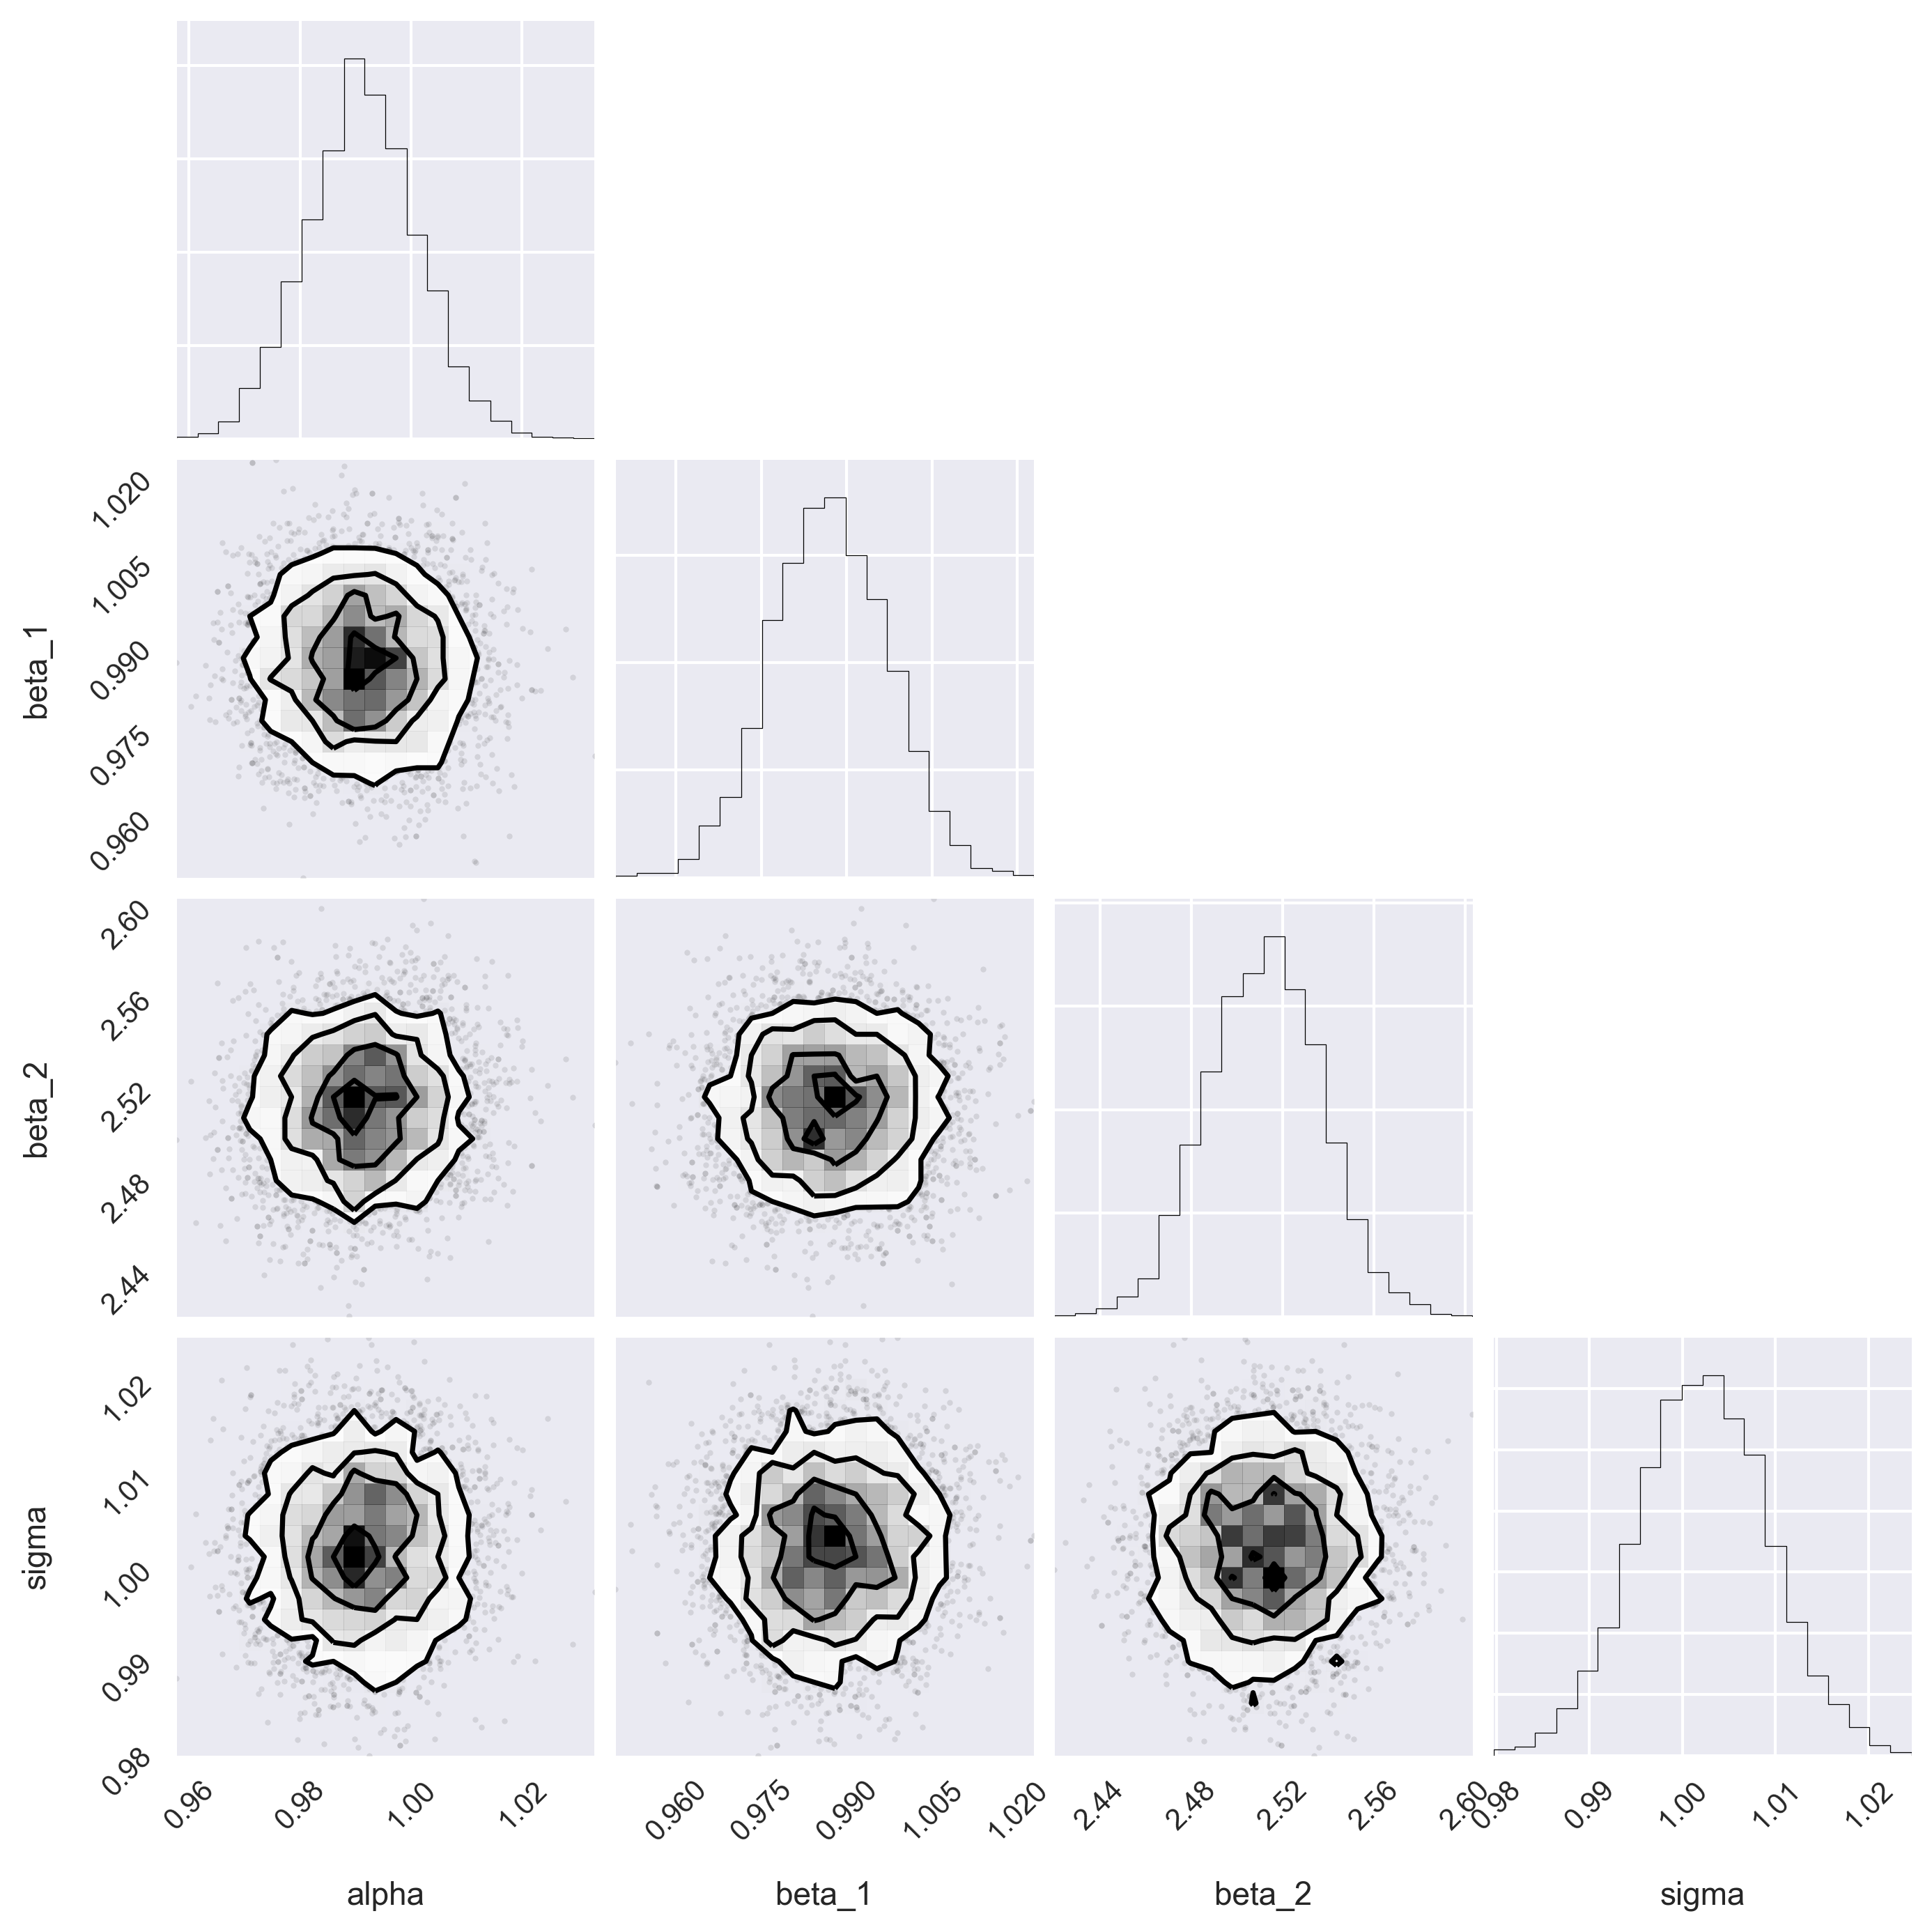

In [20]:
_ = corner.corner(df.drop('lnprob', axis=1))

In [29]:
df.iloc[np.argmax(df.lnprob)]

alpha                0.990598
beta_1               0.986696
beta_2                2.51581
sigma                 1.00324
lnprob    -14221.045801971517
Name: 4508, dtype: object

In [28]:
np.argmax?

##  Re-analyzing the MWC data.

In [30]:
# Load the data set. 
data = pd.read_csv('mwc_flow_master.csv')
data = pd.DataFrame(data[(data['operator']=='O2') & (data['rbs']=='RBS1027')])
# data = pd.DataFrame(data[(data['operator']=='O2')])
# df = pd.DataFrame(data[(data['IPTG_uM'] == 0) & (data['repressors'] > 0)])
# f.head()

In [31]:
p = bokeh.plotting.figure(plot_width=800, x_axis_type='log', x_axis_label='IPTG (µM)',
                         y_axis_label='fold-change')
p.circle(x='IPTG_uM', y='fold_change_A', source=data)
bokeh.io.show(p)

In [32]:
def pact(c_range, ep_ai, ep_a, ep_i):
    numer = (1 + c_range * np.exp(-ep_a))**2
    denom = numer + np.exp(-ep_ai) * (1 + c_range * np.exp(-ep_i))**2
    return numer/denom

def fc(ep_a, ep_i, R, ep_r, c_range, ep_ai):
    p_act = pact(c_range, ep_ai, ep_a, ep_i)
    return (1 + p_act * (R /  4.6E6) * np.exp(-ep_r))**-1


In [33]:
df.head()

alpha    beta_1    beta_2     sigma               lnprob
0  1.009685  0.991386  2.564247  0.994653  -14225.604132626706
1  1.009685  0.991386  2.564247  0.994653  -14225.604132626706
2  0.985871  0.986274  2.487080  1.019228  -14224.445070352444
3  0.997477  0.987141  2.495550  1.017868  -14223.819777220346
4  0.982440  0.994330  2.551155  0.986022  -14225.648427174547

In [34]:
import scipy.optimize
import theano.tensor as tt

In [60]:

induction = pm.Model()
def jeffreys(value):
    return -tt.log(value)

with pm.Model() as induction:
    # Set the priors. 
    ep_a = pm.Uniform('ep_a', lower=-7, upper=7, testval=4.5)
    ep_i = pm.Uniform('ep_i', lower=-7, upper=7, testval=-0.5)
    ep_ai = pm.Uniform('ep_ai', lower=-50, upper=50, testval=4.5)
    R = pm.Normal('R', 260, sd=20, testval=200)
    ep_r = pm.Normal('ep_r', mu=-13.9, sd=0.2, testval=-15)
    sigma = pm.DensityDist('sigma', jeffreys)
    
    # Compute the expected value of the outcome. 
    c = data['IPTG_uM'].values
    p_act = (1 + c * np.exp(-ep_a))**2 /\
        ((1 + c * np.exp(-ep_a))**2 + np.exp(-ep_ai) * (1 + c * np.exp(-ep_i))**2)
    foldchange = (1 + p_act * (R / 4.6E6) * np.exp(-ep_r))**-1
                
    
    # Compute the likelihood of the observations. 
    fc_obs = pm.Normal('fc_obs', mu=foldchange, sd=sigma, observed=data['fold_change_A'].values)

    # Sample
    trace = pm.sample(draws=20000, tune=10000)
    

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = 166.91: 100%|██████████| 200000/200000 [00:24<00:00, 8153.11it/s]
Finished [100%]: Average ELBO = 167.05
INFO:pymc3:Finished [100%]: Average ELBO = 167.05
100%|██████████| 20000/20000 [12:04<00:00, 27.61it/s] 


100%|██████████| 20000/20000 [00:03<00:00, 5275.90it/s]


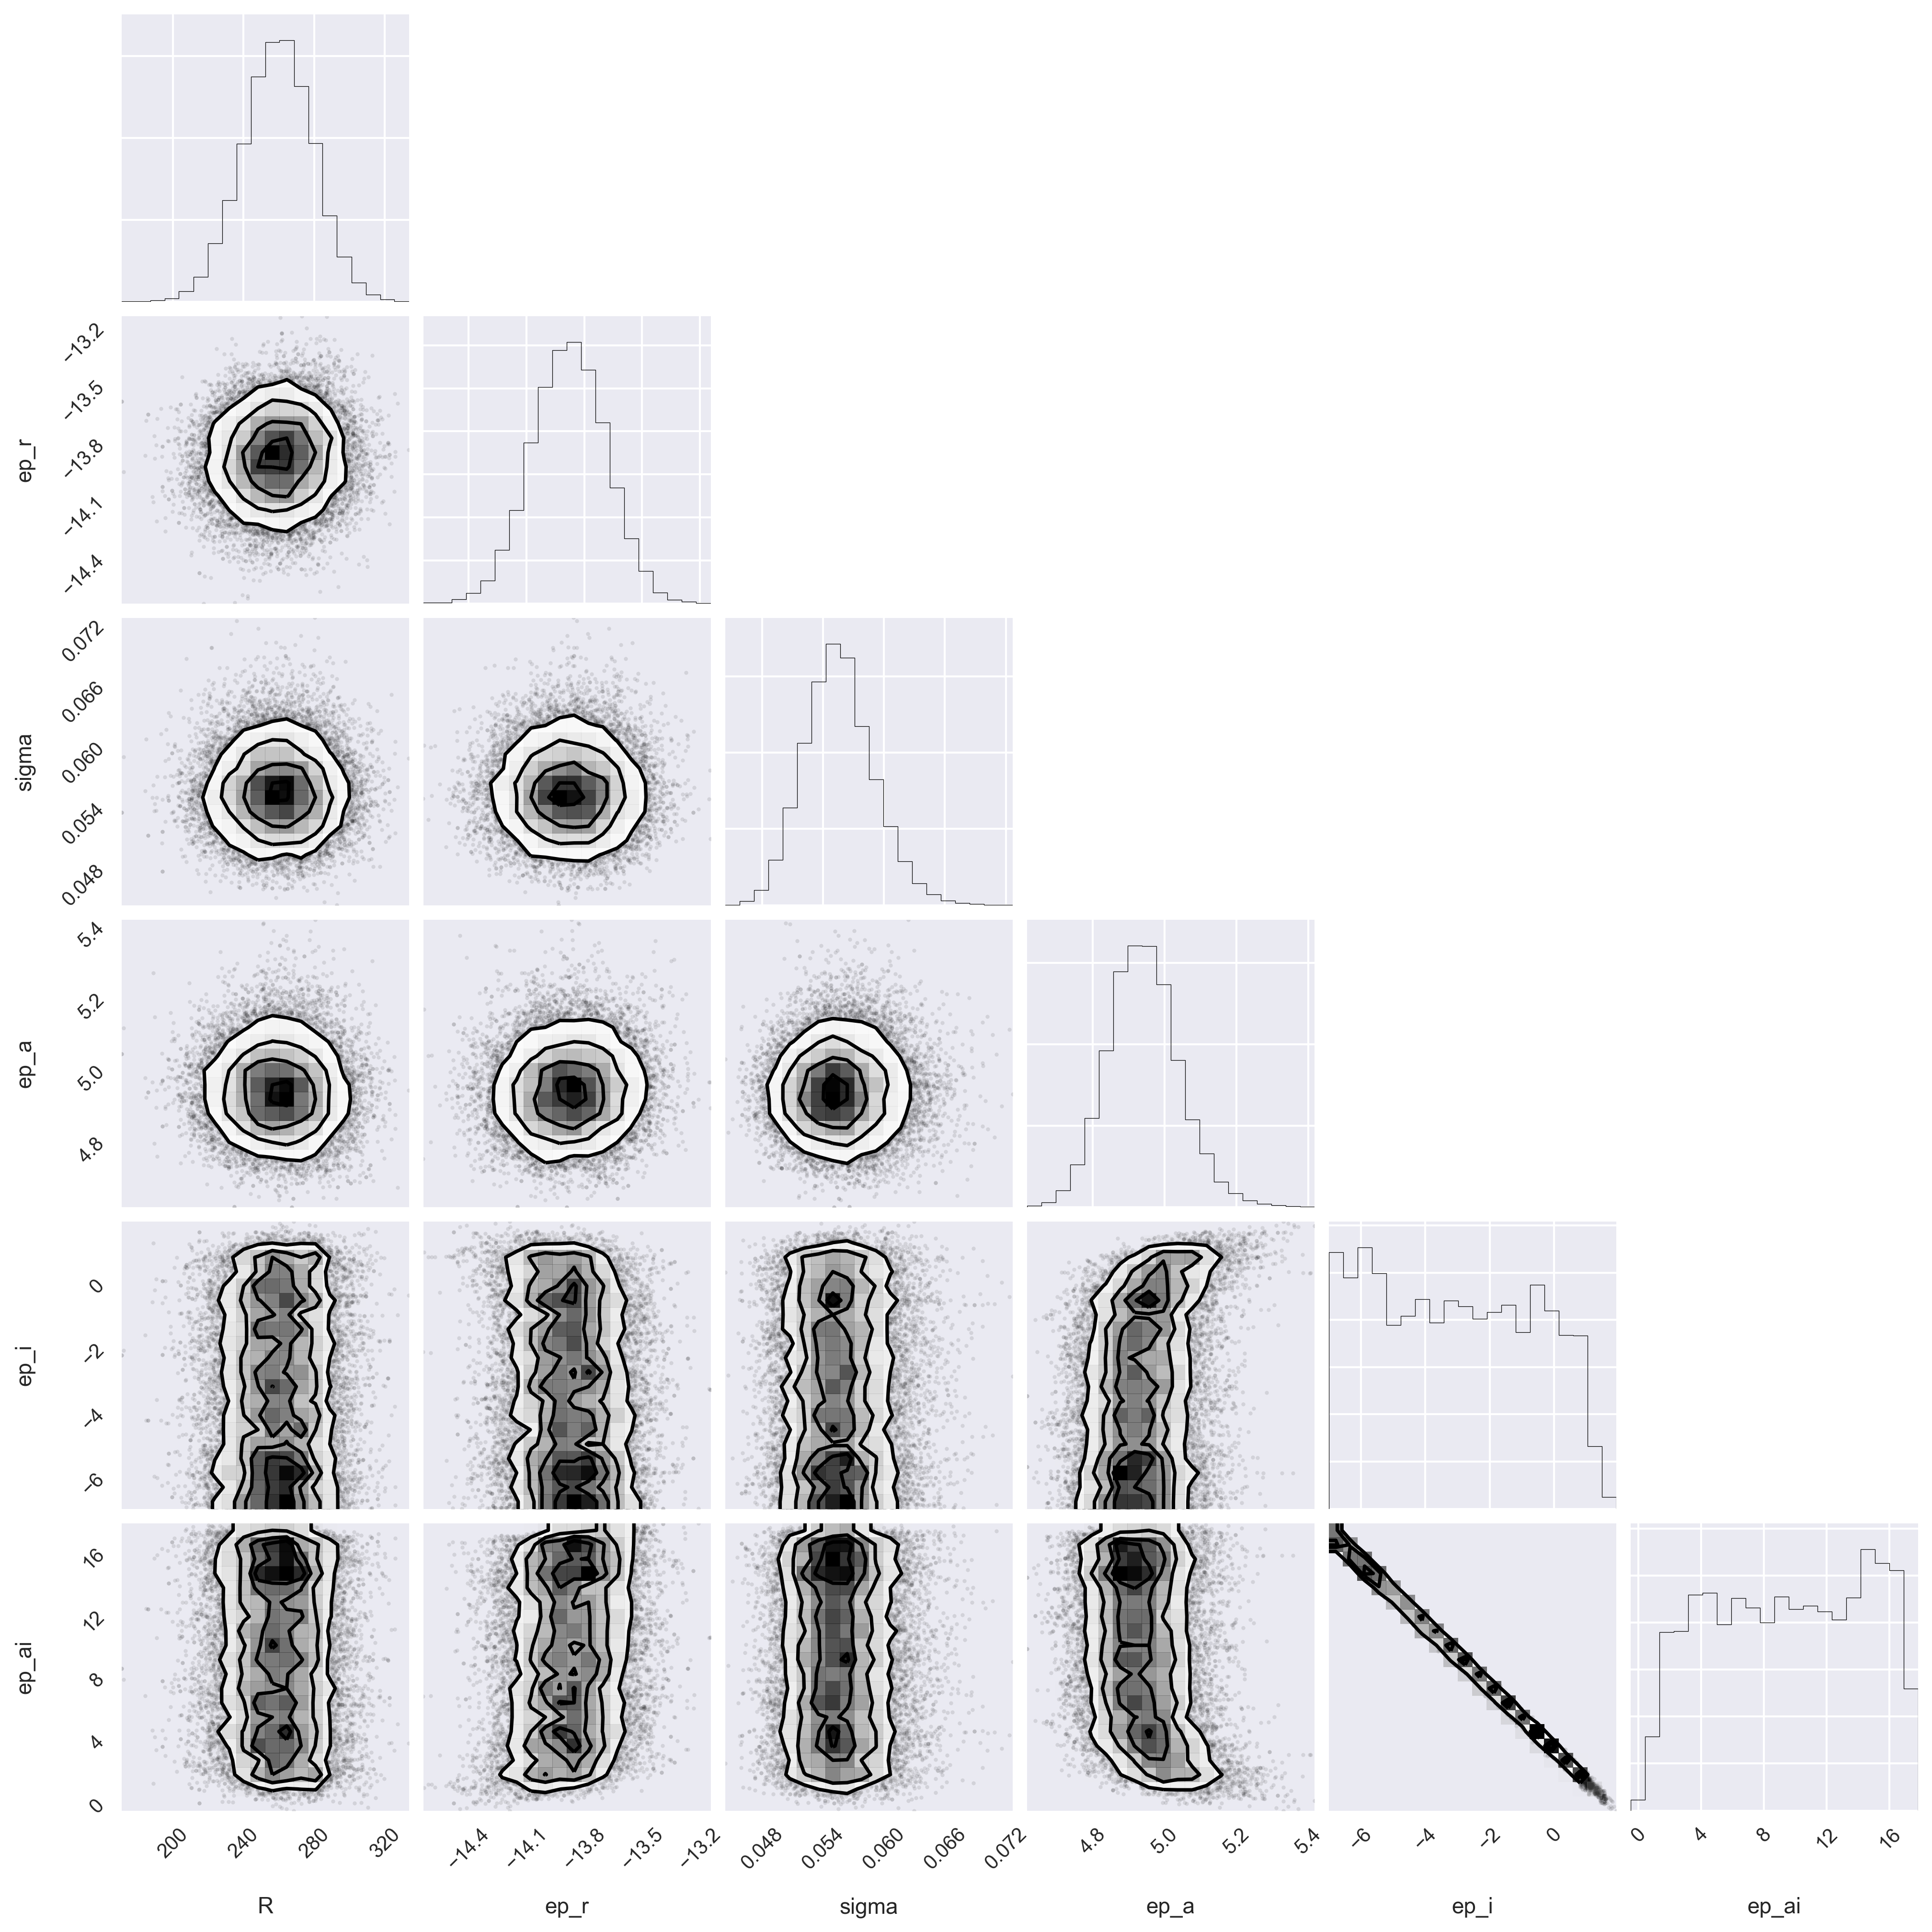

In [61]:
samp_df = traceframe(trace, induction)
_ = corner.corner(samp_df.drop('lnprob', axis=1))

In [62]:
samp_df.iloc[np.argmax(samp_df.lnprob)]

R                   256.517
ep_r               -13.8776
sigma             0.0545831
ep_a                4.91998
ep_i              -0.450825
ep_ai               4.19059
lnprob    186.3902113109298
Name: 2354, dtype: object

In [42]:
x = []
for t in trace:
    x.append(induction.logp(t))
print(len(x), len(z))

20000 120000


In [227]:
pm.summary(trace)


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.056            0.003            0.000            [0.049, 0.062]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.049          0.053          0.055          0.058          0.063


ep_a:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.950            0.092            0.001            [4.768, 5.129]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4.776          4.888          4.948          5.010          5.137


ep_i:

  Mean             SD               MC Error         95% HPD interval
  ---------------------------

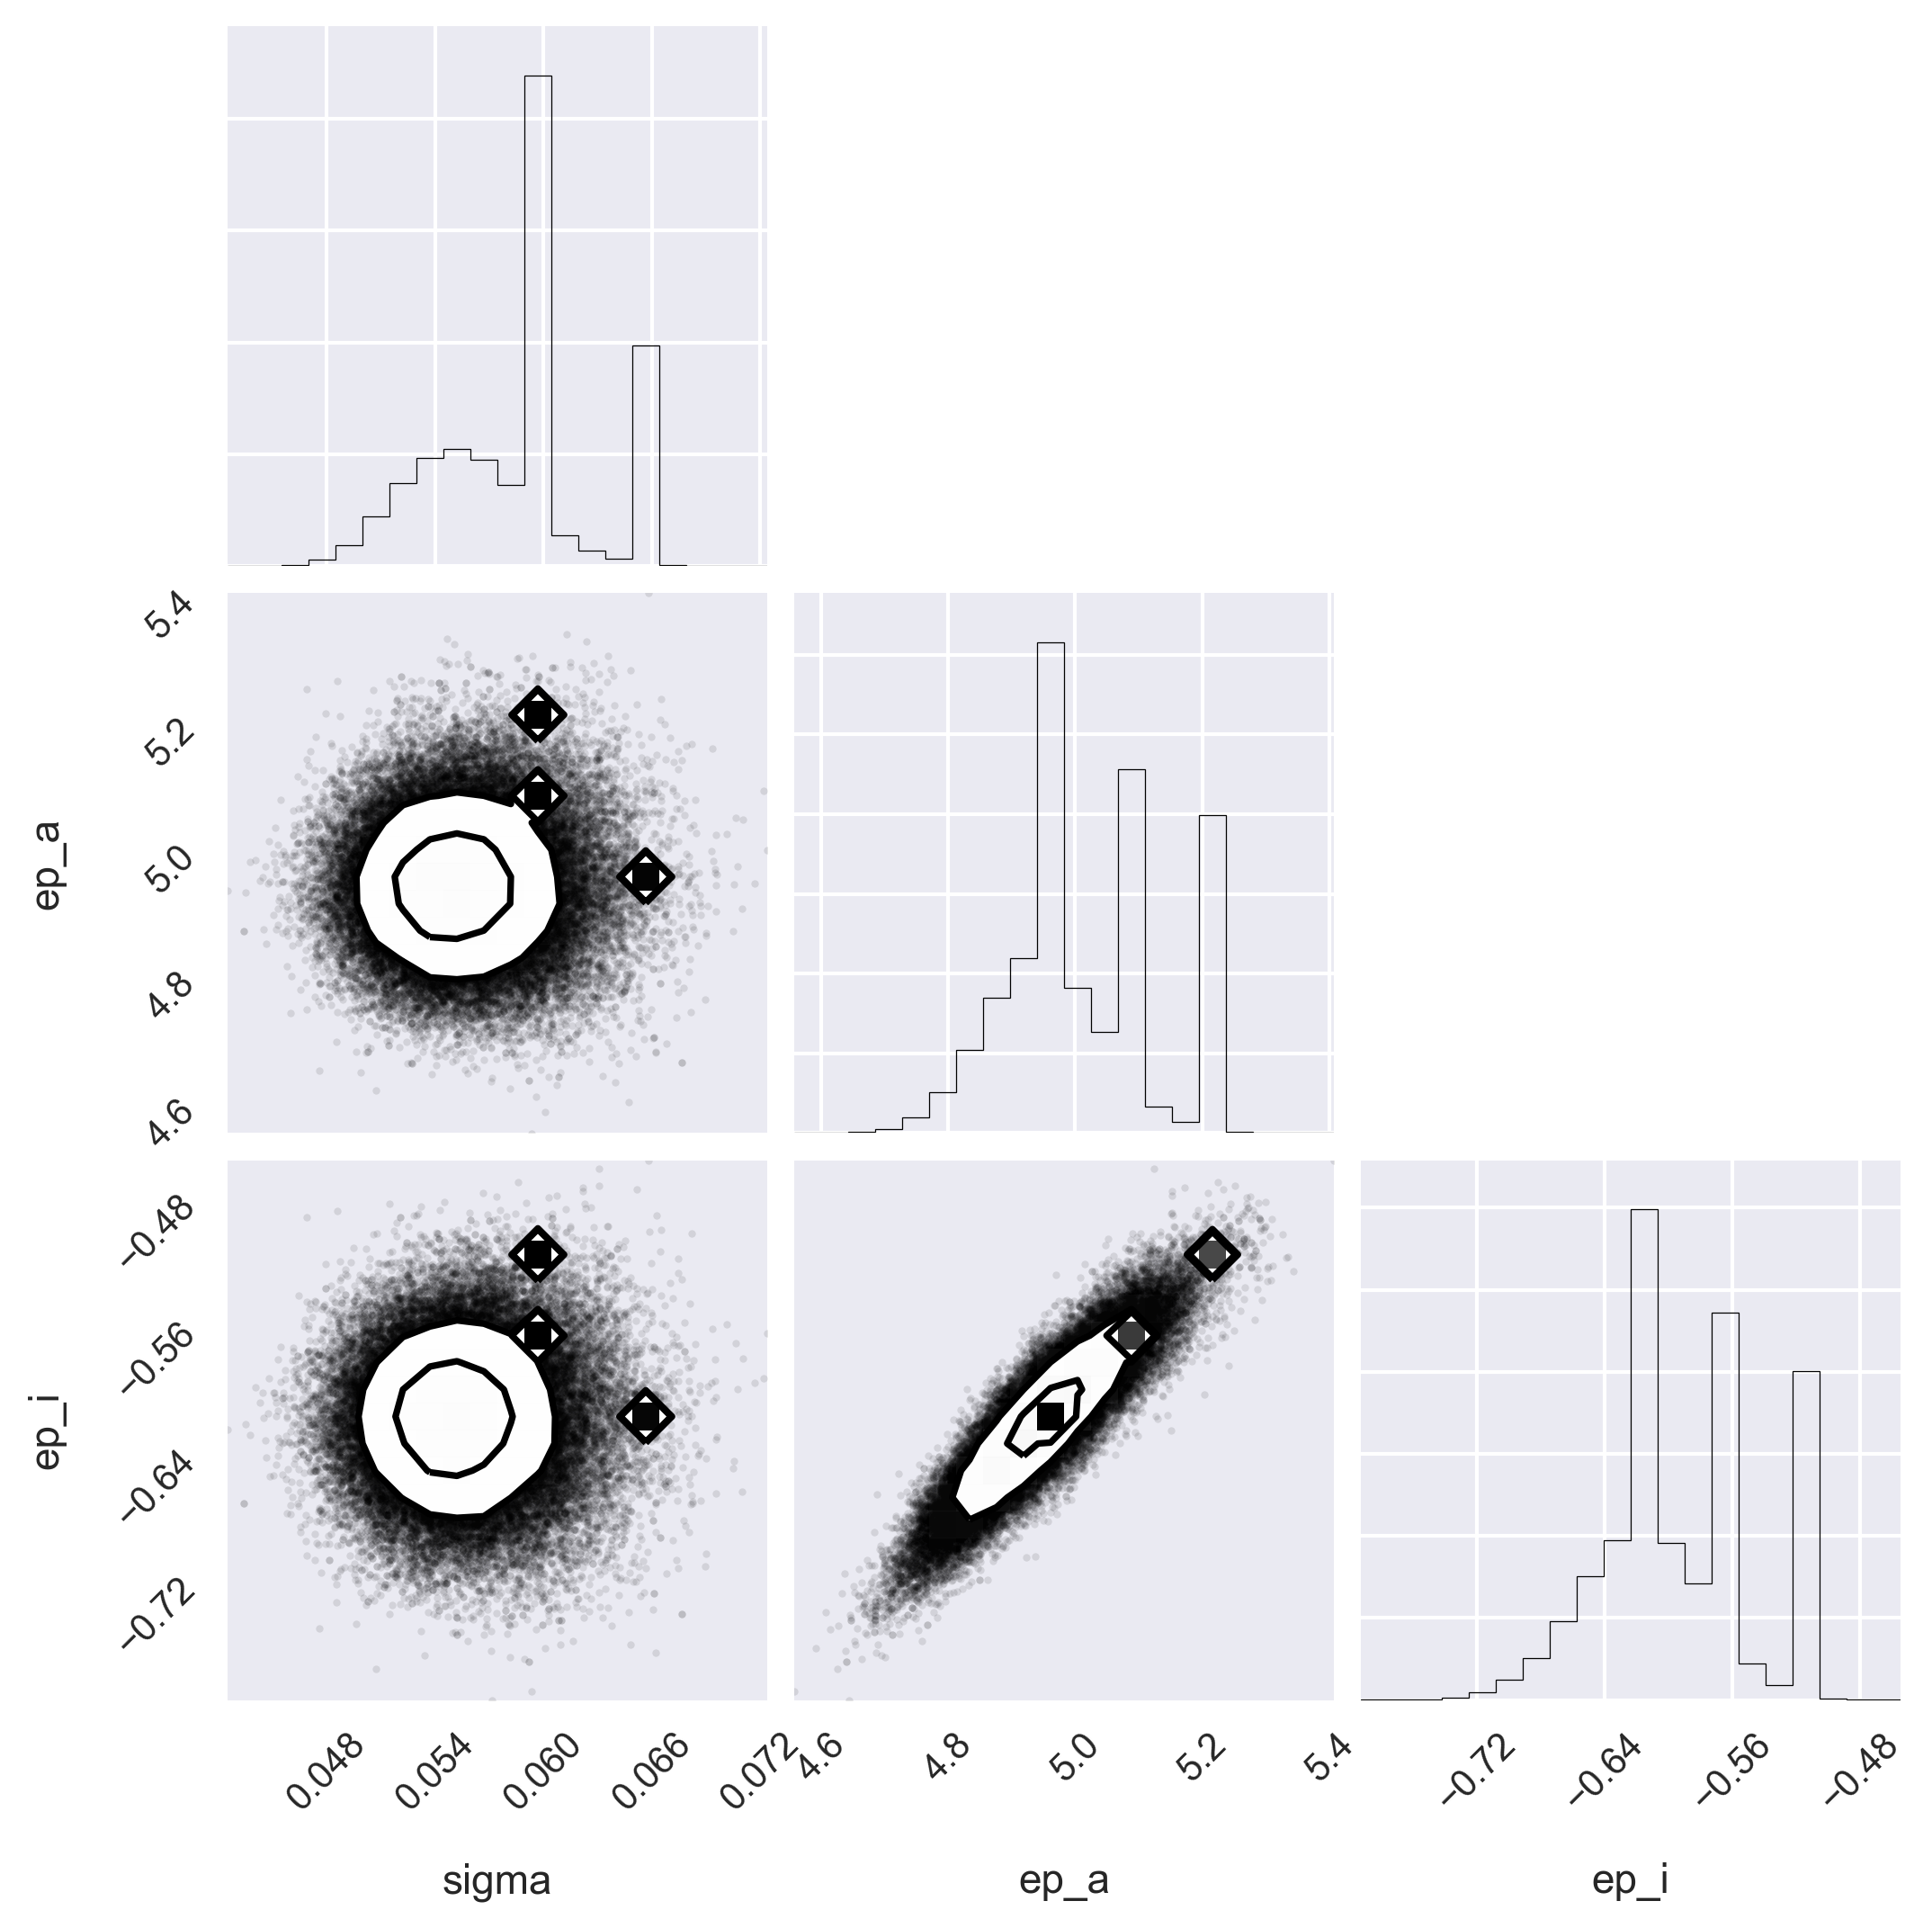

In [45]:
df = pm.trace_to_dataframe(trace)
# df['ep_a'] = np.exp(df['ep_a'])
# df['ep_i'] = np.exp(df['ep_i'])
_ = corner.corner(df)

In [244]:
ka_mode = scipy.stats.mode(df['ep_a'])[0]
ka_hpd = [np.percentile(df['ep_a'], 97.5), np.percentile(df['ep_a'], 2.5)]
ki_mode = scipy.stats.mode(df['ep_i'])[0]
ki_hpd = [np.percentile(df['ep_i'], 97.5), np.percentile( df['ep_i'], 2.5)]


Ka = 131.44 +-38.72 -250.05 µM
 Ki = 0.525 +-0.057697 -1.024


In [256]:
print('Ka = {0:.2f} +{1:.2f} -{2:.2f} µM\n Ki = {3:.2f} +{4:.2f} -{5:.2f} µM'.format(
    ka_mode[0], ka_hpd[0] - ka_mode[0], ka_mode[0] - ka_hpd[1],\
    ki_mode[0], ki_hpd[0] - ki_mode[0], ki_mode[0] - ki_hpd[1]))

Ka = 131.44 +38.72 -12.83 µM
 Ki = 0.52 +0.06 -0.03 µM


In [252]:
ki_hpd

[0.58227423844064552, 0.49935871096629891]

In [254]:
ki_mode[0]

0.52457730284735793

In [44]:
pm.sample?